In [ ]:
# Run Date: Monday, June 05, 2023
# Run Time: 03:55:37

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

# 🎶 Music Generation - MuseGAN

In this notebook, we'll walk through the steps required to train your own MuseGAN model to generate music in the style of the Bach chorales

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import os
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    callbacks,
    initializers,
    metrics,
)

from musegan_utils import notes_to_midi, draw_score

2023-06-05 19:54:40.898049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 19:54:41.011036: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 0. Parameters <a name="parameters"></a>

In [3]:
BATCH_SIZE = 64

N_BARS = 2
N_STEPS_PER_BAR = 16
MAX_PITCH = 83
N_PITCHES = MAX_PITCH + 1
Z_DIM = 32


CRITIC_STEPS = 5
GP_WEIGHT = 10
CRITIC_LEARNING_RATE = 0.001
GENERATOR_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 6000
LOAD_MODEL = False

## 1. Prepare the Data

In [4]:
dataFolder = '/tf/All/Data/Documents/Github/davidADSP/data/Bach-Chorales'

In [5]:
# Load the data
file = os.path.join(dataFolder + "/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

In [6]:
N_SONGS = len(data)
print(f"{N_SONGS} chorales in the dataset")
chorale = data[0]
N_BEATS, N_TRACKS = chorale.shape
print(f"{N_BEATS, N_TRACKS} shape of chorale 0")
print("\nChorale 0")
print(chorale[:8])

229 chorales in the dataset
(192, 4) shape of chorale 0

Chorale 0
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]


In [7]:
two_bars = np.array([x[: (N_STEPS_PER_BAR * N_BARS)] for x in data])
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype=int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f"Two bars shape {two_bars.shape}")

Two bars shape (229, 2, 16, 4)


In [8]:
data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
print(f"Data binary shape {data_binary.shape}")

Data binary shape (229, 2, 16, 84, 4)


## 2. Build the GAN <a name="build"></a>

In [9]:
# Some helper functions

initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)


def conv(x, f, k, s, p):
    x = layers.Conv3D(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    x = layers.LeakyReLU()(x)
    return x


def conv_t(x, f, k, s, a, p, bn):
    x = layers.Conv2DTranspose(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)

    x = layers.Activation(a)(x)
    return x

In [10]:
def TemporalNetwork():
    input_layer = layers.Input(shape=(Z_DIM,), name="temporal_input")
    x = layers.Reshape([1, 1, Z_DIM])(input_layer)
    x = conv_t(x, f=1024, k=(2, 1), s=(1, 1), a="relu", p="valid", bn=True)
    x = conv_t(
        x, f=Z_DIM, k=(N_BARS - 1, 1), s=(1, 1), a="relu", p="valid", bn=True
    )
    output_layer = layers.Reshape([N_BARS, Z_DIM])(x)
    return models.Model(input_layer, output_layer)


TemporalNetwork().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer)  [(None, 32)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 1, 1024)       66560     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 2, 1, 1024)       4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2, 1, 1024)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 2, 1, 32)         32800 

2023-06-05 19:54:42.945214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 19:54:42.945400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 19:54:42.947245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 19:54:42.947397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 19:54:42.947572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [11]:
def BarGenerator():
    input_layer = layers.Input(shape=(Z_DIM * 4,), name="bar_generator_input")

    x = layers.Dense(1024)(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation("relu")(x)
    x = layers.Reshape([2, 1, 512])(x)

    x = conv_t(x, f=512, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(1, 7), s=(1, 7), a="relu", p="same", bn=True)
    x = conv_t(x, f=1, k=(1, 12), s=(1, 12), a="tanh", p="same", bn=False)

    output_layer = layers.Reshape([1, N_STEPS_PER_BAR, N_PITCHES, 1])(x)

    return models.Model(input_layer, output_layer)


BarGenerator().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bar_generator_input (InputL  [(None, 128)]            0         
 ayer)                                                           
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 1, 512)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 4, 1, 512)        5248

In [12]:
def Generator():
    chords_input = layers.Input(shape=(Z_DIM,), name="chords_input")
    style_input = layers.Input(shape=(Z_DIM,), name="style_input")
    melody_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="melody_input")
    groove_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="groove_input")

    # CHORDS -> TEMPORAL NETWORK
    chords_tempNetwork = TemporalNetwork()
    chords_over_time = chords_tempNetwork(chords_input)  # [n_bars, z_dim]

    # MELODY -> TEMPORAL NETWORK
    melody_over_time = [
        None
    ] * N_TRACKS  # list of n_tracks [n_bars, z_dim] tensors
    melody_tempNetwork = [None] * N_TRACKS
    for track in range(N_TRACKS):
        melody_tempNetwork[track] = TemporalNetwork()
        melody_track = layers.Lambda(lambda x, track=track: x[:, track, :])(
            melody_input
        )
        melody_over_time[track] = melody_tempNetwork[track](melody_track)

    # CREATE BAR GENERATOR FOR EACH TRACK
    barGen = [None] * N_TRACKS
    for track in range(N_TRACKS):
        barGen[track] = BarGenerator()

    # CREATE OUTPUT FOR EVERY TRACK AND BAR
    bars_output = [None] * N_BARS
    c = [None] * N_BARS
    for bar in range(N_BARS):
        track_output = [None] * N_TRACKS

        c[bar] = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
            chords_over_time
        )  # [z_dim]
        s = style_input  # [z_dim]

        for track in range(N_TRACKS):
            m = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
                melody_over_time[track]
            )  # [z_dim]
            g = layers.Lambda(lambda x, track=track: x[:, track, :])(
                groove_input
            )  # [z_dim]

            z_input = layers.Concatenate(
                axis=1, name="total_input_bar_{}_track_{}".format(bar, track)
            )([c[bar], s, m, g])

            track_output[track] = barGen[track](z_input)

        bars_output[bar] = layers.Concatenate(axis=-1)(track_output)

    generator_output = layers.Concatenate(axis=1, name="concat_bars")(
        bars_output
    )

    return models.Model(
        [chords_input, style_input, melody_input, groove_input],
        generator_output,
    )


generator = Generator()
# generator.summary()

In [13]:
def Critic():
    critic_input = layers.Input(
        shape=(N_BARS, N_STEPS_PER_BAR, N_PITCHES, N_TRACKS),
        name="critic_input",
    )

    x = critic_input

    x = conv(x, f=128, k=(2, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(N_BARS - 1, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(1, 1, 12), s=(1, 1, 12), p="same")
    x = conv(x, f=128, k=(1, 1, 7), s=(1, 1, 7), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=256, k=(1, 4, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=512, k=(1, 3, 1), s=(1, 2, 1), p="same")

    x = layers.Flatten()(x)

    x = layers.Dense(1024, kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)

    critic_output = layers.Dense(
        1, activation=None, kernel_initializer=initializer
    )(x)

    return models.Model(critic_input, critic_output)


critic = Critic()
# critic.summary()

In [14]:
class MuseGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(MuseGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(MuseGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            chords_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            style_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            melody_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )
            groove_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )

            random_latent_vectors = [
                chords_random_latent_vectors,
                style_random_latent_vectors,
                melody_random_latent_vectors,
                groove_random_latent_vectors,
            ]

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        chords_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )

        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

    def generate_piano_roll(self, num_scores):
        chords_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]
        generated_music = self.generator(random_latent_vectors)
        generated_music = generated_music.numpy()
        return generated_music

In [15]:
# Create a MuseGAN
musegan = MuseGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [16]:
if LOAD_MODEL:
    musegan.load_weights("11_02_musegan/checkpoint/checkpoint.ckpt")

## 3. Train the MuseGAN <a name="train"></a>

In [17]:
# Compile the GAN
musegan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
)

In [18]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="11_02_musegan/checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="11_02_musegan/logs")


class MusicGenerator(callbacks.Callback):
    def __init__(self, num_scores):
        self.num_scores = num_scores

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            generated_music = self.model.generate_piano_roll(self.num_scores)
            notes_to_midi(
                generated_music,
                N_BARS,
                N_TRACKS,
                N_STEPS_PER_BAR,
                filename="output_" + str(epoch).zfill(4),
            )
            # display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)


music_generator_callback = MusicGenerator(1)

In [19]:
%%time
history = musegan.fit(
    data_binary,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator_callback,
    ],
)

Epoch 1/6000


2023-06-05 19:55:11.335515: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


8/8 [==============================] - 30s 327ms/step - c_loss: -392.5236 - c_wass_loss: -1200.7277 - c_gp: 80.8204 - g_loss: -191.2320
Epoch 2/6000
8/8 [==============================] - 2s 280ms/step - c_loss: -123.5182 - c_wass_loss: -191.8484 - c_gp: 6.8330 - g_loss: -457.5372
Epoch 3/6000
8/8 [==============================] - 2s 279ms/step - c_loss: -62.4154 - c_wass_loss: -94.3695 - c_gp: 3.1954 - g_loss: -1476.2113
Epoch 4/6000
8/8 [==============================] - 2s 281ms/step - c_loss: -64.5141 - c_wass_loss: -106.6722 - c_gp: 4.2158 - g_loss: -1023.7485
Epoch 5/6000
8/8 [==============================] - 2s 280ms/step - c_loss: -70.1530 - c_wass_loss: -104.5818 - c_gp: 3.4429 - g_loss: -864.0012
Epoch 6/6000
8/8 [==============================] - 2s 281ms/step - c_loss: -68.6161 - c_wass_loss: -97.1404 - c_gp: 2.8524 - g_loss: -809.7181
Epoch 7/6000
8/8 [==============================] - 2s 281ms/step - c_loss: -71.3868 - c_wass_loss: -107.8863 - c_gp: 3.6499 - g_loss: -75

# Generate new scores

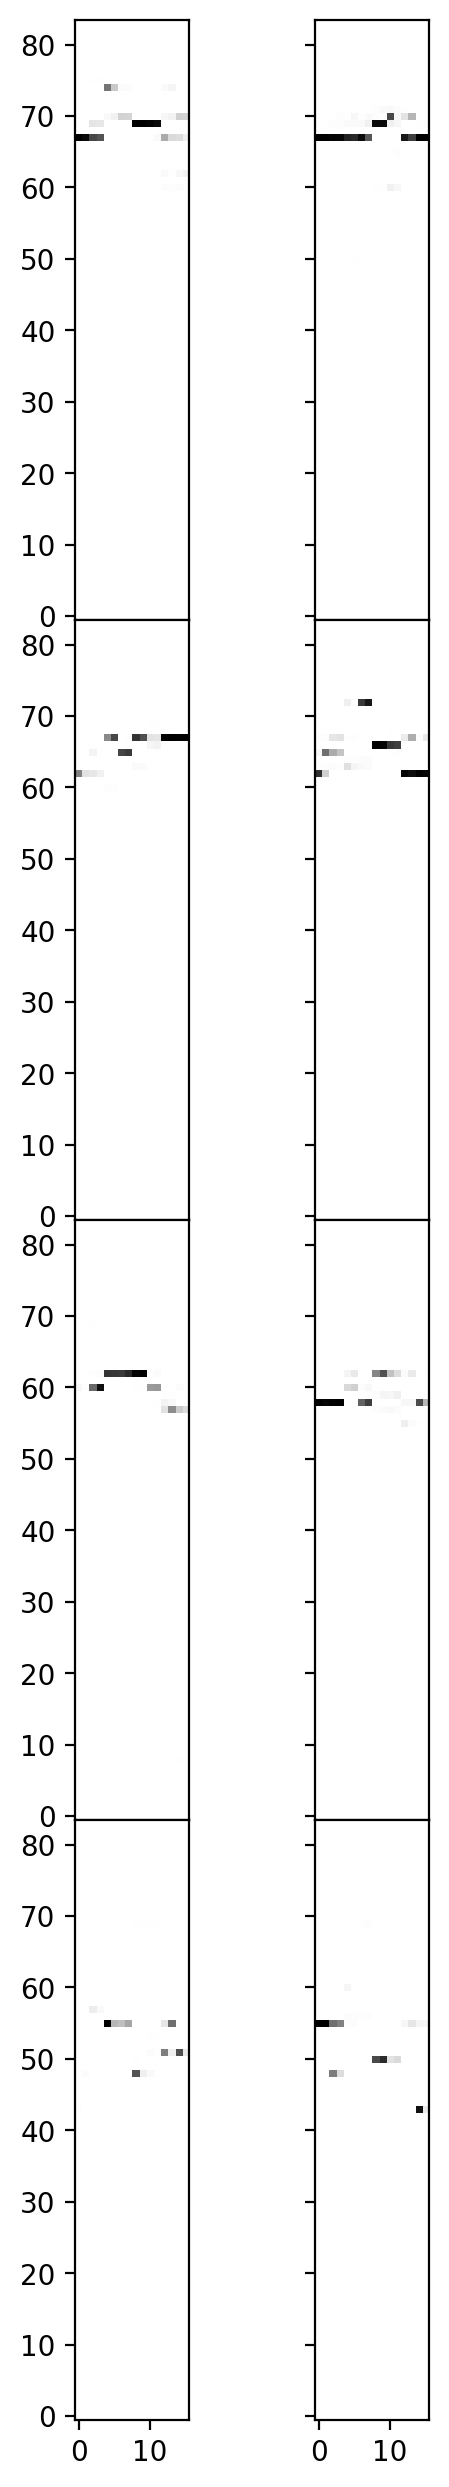

In [20]:
num_scores = 1
chords_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
style_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
melody_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
groove_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
random_latent_vectors = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music = generator(random_latent_vectors)
generated_music = generated_music.numpy()

draw_score(generated_music, 0)
notes_to_midi(
    generated_music, N_BARS, N_TRACKS, N_STEPS_PER_BAR, filename="output_midi"
)

## Changing Chord Noise

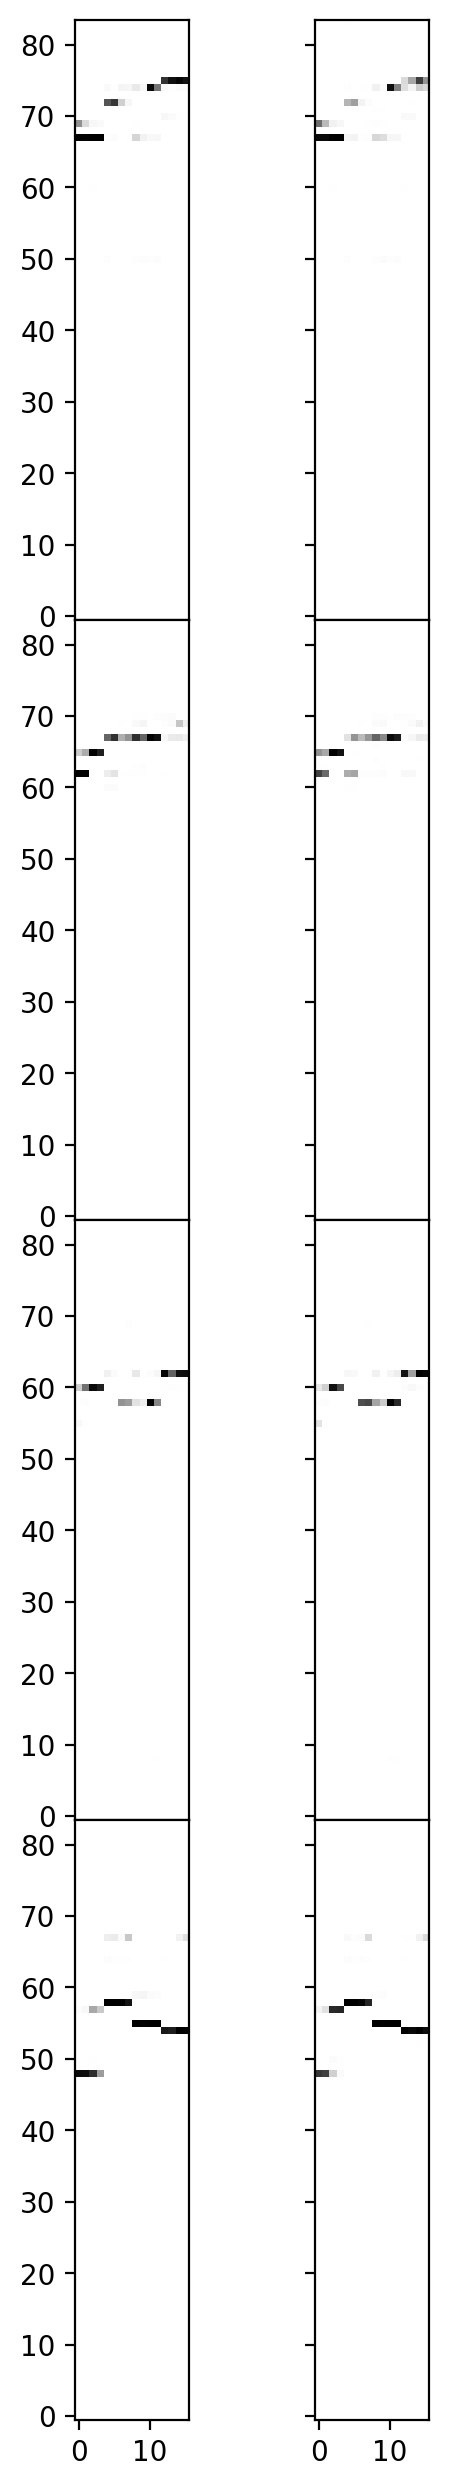

In [21]:
chords_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_2 = [
    chords_random_latent_vectors_2,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_2 = generator(random_latent_vectors_2)
generated_music_2 = generated_music_2.numpy()
draw_score(generated_music_2, 0)
notes_to_midi(
    generated_music_2,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_chords_changed",
)

# Changing Style Noise

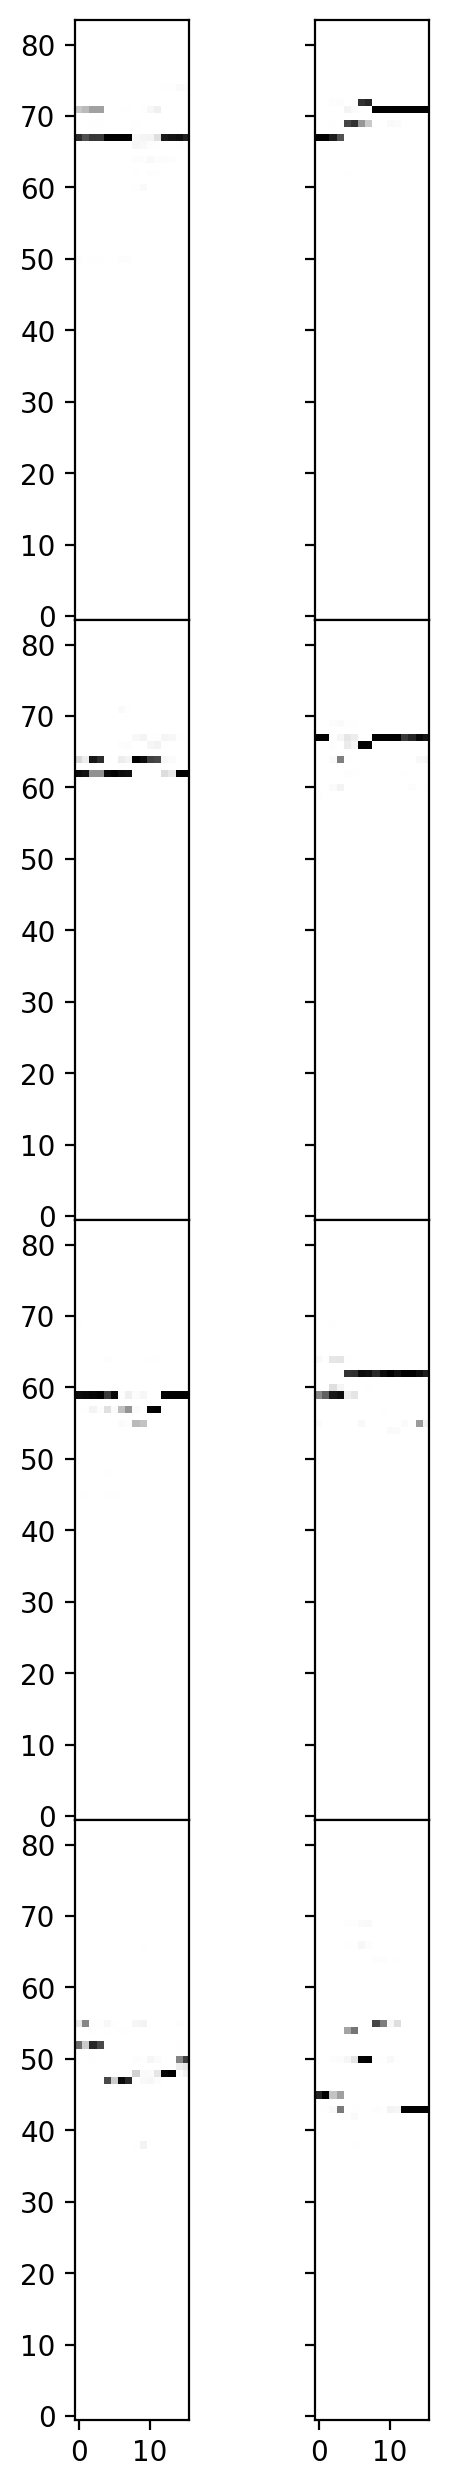

In [22]:
style_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_3 = [
    chords_random_latent_vectors,
    style_random_latent_vectors_2,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_3 = generator(random_latent_vectors_3)
generated_music_3 = generated_music_3.numpy()
draw_score(generated_music_3, 0)
notes_to_midi(
    generated_music_3,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_style_changed",
)

## Changing Melody Noise

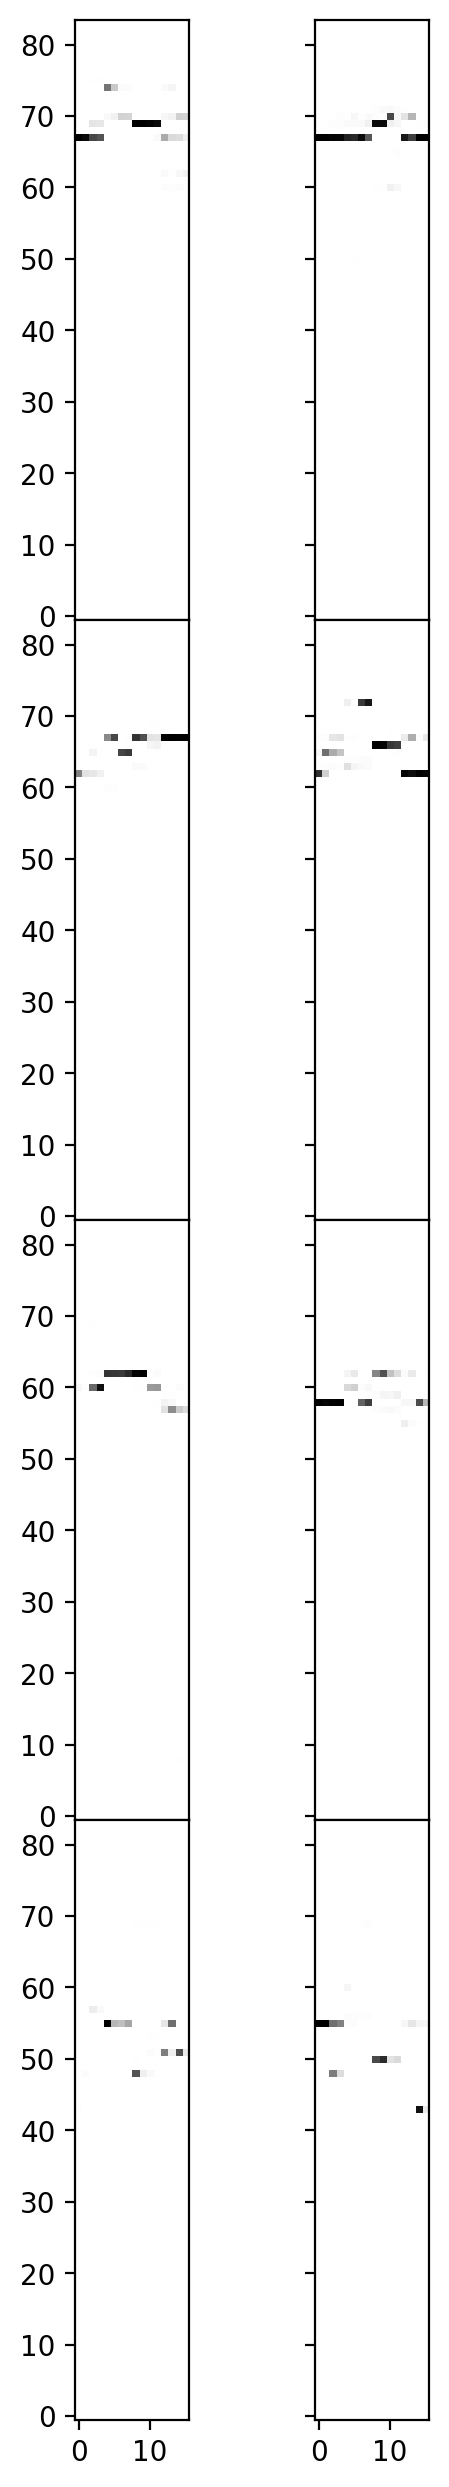

In [23]:
melody_random_latent_vectors_2 = np.copy(melody_random_latent_vectors)
melody_random_latent_vectors_2[:, 0, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_4 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors_2,
    groove_random_latent_vectors,
]
generated_music_4 = generator(random_latent_vectors_4)
generated_music_4 = generated_music_4.numpy()
draw_score(generated_music_4, 0)
notes_to_midi(
    generated_music_4,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_melody_changed",
)

## Changing groove noise

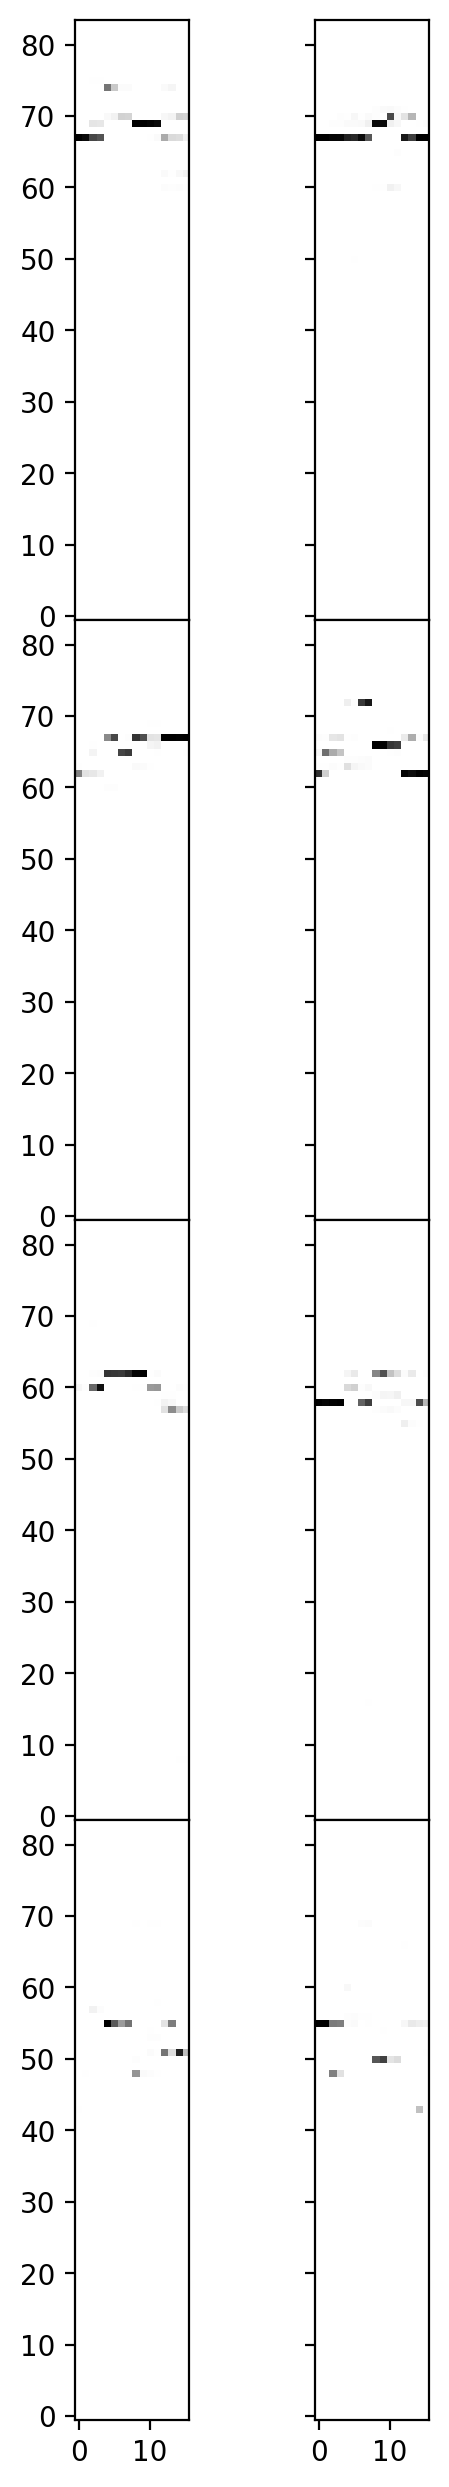

In [24]:
groove_random_latent_vectors_2 = np.copy(groove_random_latent_vectors)
groove_random_latent_vectors_2[:, -1, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_5 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors_2,
]
generated_music_5 = generator(random_latent_vectors_5)
generated_music_5 = generated_music_5.numpy()
draw_score(generated_music_5, 0)
notes_to_midi(
    generated_music_5,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_groove_changed",
)

In [25]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Monday, June 05, 2023
# Run Time: 03:55:37
